<a href="https://colab.research.google.com/github/NicolaGabriele/powerline_Segmentation_project/blob/main/projectYOLACT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IMPORT DELLE LIBRERIE E CARICAMENTO DEL DATASET**


In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.tv_tensors import BoundingBoxes, BoundingBoxFormat, Mask
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
import random
import pycocotools
from pycocotools import mask
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.autograd import Variable
TRAIN_DIR = '/content/drive/MyDrive/trainingset'#'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\trainingset'#
TEST_DIR = '/content/drive/MyDrive/testset'#'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\testset'#
TRAIN_LABELS = '/content/drive/MyDrive/train.json'#'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\train.json'#
TEST_LABELS =  '/content/drive/MyDrive/test.json'#'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\test.json'
IM_WIDTH = 700
IM_HEIGHT = 700
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def groupByImageId(jsonfile):
  data = jsonfile['annotations']
  labs = {}
  for k in data:
    if k['image_id'] in labs:
      labs[k['image_id']].append(k)
    else:
      labs[k['image_id']] = [k]
  return labs

In [4]:
def decodeSegmentationField(segmentation):
  return mask.decode(mask.merge(mask.frPyObjects(segmentation,IM_WIDTH,IM_HEIGHT)))

In [5]:
def formatLabels(labels):
  bbox = []
  seg = []
  cls = []
  i = 0
  for label in labels:
    seg.append(decodeSegmentationField(label['segmentation']))
    b = label['bbox']
    box = [b[0],b[1],b[0]+b[2], b[1]+b[3]]
    if(box[2]-box[0] <= 0):
      box[2]+=1
    if(box[3]-box[1] <= 0):
      box[3]+=1
    bbox.append(box)
    i+=1
    cls.append(label['category_id']+1)
  return  {
      'boxes': torchvision.tv_tensors.BoundingBoxes(data=np.array(bbox),format = BoundingBoxFormat.XYXY, canvas_size=(IM_WIDTH, IM_HEIGHT)),
      'labels': torch.tensor(cls, dtype = torch.int64),
      'image_id': label['image_id'],
      'area': torch.tensor(label['area'], dtype=torch.float64),
      'iscrowd': torch.tensor(label['iscrowd'], dtype=torch.uint8),
      'masks': Mask(seg)
  }

In [6]:
class PowerLineDataset(torch.utils.data.Dataset):
  def __init__(self,img_dir,img_labels):
    self.img_dir = img_dir
    self.img_labels = json.load(open(img_labels))
    self.categories = {} #lista delle etichette di classe
    for c in self.img_labels['categories']:
      self.categories[c['name']] = c['id']+1 #incrementiamo di uno per distinguere la background class

  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir, self.img_labels['images'][idx]['file_name'])
    label = groupByImageId(self.img_labels)[idx]
    image = (torchvision.io.read_image(img_path)/255)
    #tra = torchvision.transforms.Resize((700,700))
    return (image,formatLabels(label))
  def __len__(self):
    return len(os.listdir(self.img_dir))


In [7]:
#caricamento dei dataset di train e di test
trainset = PowerLineDataset(TRAIN_DIR, TRAIN_LABELS)
test = PowerLineDataset(TEST_DIR, TEST_LABELS)

##***MODEL TRAINING***

In [8]:
def targetsToDevice(targets, device):
  return [{
      'boxes': target['boxes'].to(device),
      'labels': target['labels'].to(device),
      'image_id': target['image_id'],
      'area': target['area'].to(device),
      'iscrowd':target['boxes'].to(device),
      'masks': target['masks'].to(device)
  } for target in targets]

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
model.train()
#model.to(device)
#predictions = model([trainset[3][0]], [formatLabels(trainset[3][1])])
learning_rate = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
batch_size = 4
trains = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True,collate_fn= collate_fn)
total_step = len(trains)

num_epochs = 50

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trains) for i in range(num_epochs + 1)]


def train(epoch,model,optimizer):
    for batch_idx, (images, targets) in enumerate(trains):
        # Move tensors to the configured device
        #if reshape:
         #   images = images.reshape(-1, 28*28)
        #images = images.to('cuda')
        #labels = labels.to('cuda')
        images = [image.to(device) for image in images]
        targets = targetsToDevice(targets,device)
        # Forward pass
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        #backward pass
        losses.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        if (batch_idx+1) % 1 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, num_epochs, batch_idx+1, total_step, losses))

        train_losses.append(losses)
        train_counter.append(
        (batch_idx*batch_size) + ((epoch-1)*len(trains)))

In [ ]:
for epoch in range(37,num_epochs+1):
  train(epoch=epoch, model = model, optimizer = optimizer)
  torch.save(model, '/content/drive/MyDrive/maskrcnn_{}ep'.format(epoch))

##***MODEL EVALUATION***

In [ ]:
#GENERAZIONE DEL FILE JSON IN FORMATO COCO
#costruisco il dataloader per il test set
model.eval()
batch_size = 1
testloader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False, collate_fn = collate_fn)

results = []
j = 0
for idx, (images, targets) in enumerate(testloader):

  prediction = model([image.to(device) for image in images])[0]
  classes = prediction['labels'].cpu().numpy()
  scores = prediction['scores'].cpu().detach().numpy()
  boxes = prediction['boxes'].view(-1,4).cpu().detach().numpy()
  masks = prediction['masks'].view(-1,IM_HEIGHT,IM_WIDTH).cpu().detach()
  masks = torch.where(masks>0.5,1,0).numpy()
  #controllare shape
  for i in range(masks.shape[0]):
    image_id = targets[0]['image_id']
    bbox = [boxes[i][0],boxes[i][1],boxes[i][2]-boxes[i][0],boxes[i][3]-boxes[i][1]]
    bbox = [round(float(x)*10)/10 for x in bbox]
    rle = pycocotools.mask.encode(np.asfortranarray(masks[i].astype(np.uint8)))
    rle['counts'] = rle['counts'].decode('ascii')
    j+=1
    results.append({
                'image_id': int(image_id),
                'category_id': int(classes[i])-1,
                'bbox': bbox,
                'segmentation': rle,
                'score': float(scores[i]),
                'area': bbox[2]*bbox[3],
                'height': IM_HEIGHT,
                'width': IM_WIDTH,
                'id':j
            })

  torch.cuda.empty_cache()
with open('/content/drive/MyDrive/pred.json', 'w') as fp:
    json.dump(results, fp)


/usr/local/lib/python3.10/dist-packages/torchvision/tv_tensors/_tv_tensor.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.as_tensor(data, dtype=dtype, device=device).requires_grad_(requires_grad)


KeyboardInterrupt: ignored

In [ ]:
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
test = '/content/drive/MyDrive/test.json'
pred = '/content/drive/MyDrive/pred.json'
gt = COCO(test)
detections = gt.loadRes(pred)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!


In [ ]:
imgIds=sorted(gt.getImgIds())
imgIds=imgIds[0:100]
imgId = imgIds[np.random.randint(100)]

In [ ]:
annType = 'bbox'
cocoEval = COCOeval(gt, detections, annType)
cocoEval.params.imgIds = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.46s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.469
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.688
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.509
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.427
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.548
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

In [ ]:
annType = 'segm'
cocoEval = COCOeval(gt, detections, annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.54s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.245
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.305
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

In [ ]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
def visualize(img, model, view_boxes = True, view_masks = True):
  prediction = model([img])
  im = torch.tensor((img*255).cpu().numpy().astype(np.uint8),dtype=torch.uint8)
  result = im
  if view_boxes:
    result = draw_bounding_boxes(image=im,boxes=prediction[0]['boxes'],width=3)
  if view_masks:
    masks=torch.squeeze(prediction[0]['masks'])
    masks = torch.where(masks>0.5,True,False)
    result = draw_segmentation_masks(image = result,masks=masks,alpha=0.5)
  return result

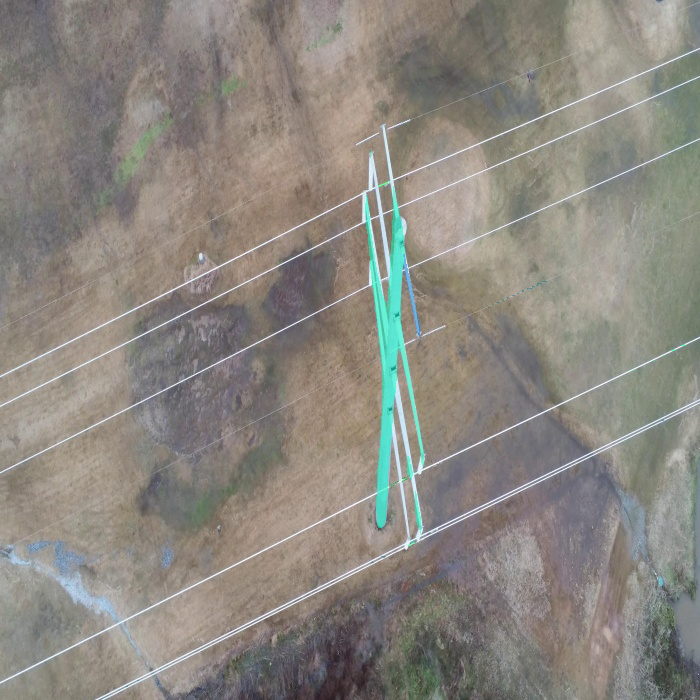

In [ ]:
model.eval()
i = np.random.randint(0,len(trainset)-1)
r = visualize(trainset[i][0].to(device),model, view_boxes=False)
torchvision.transforms.ToPILImage()(r)

#***RESNET***

In [10]:
class ResidualBlock(nn.Module):
  def __init__(self,in_channels, bn_channels, stride = 1, bottleneck = False):
    super(ResidualBlock, self).__init__()

    if bottleneck:
      self.expansion = 4
    else:
      self.expansion = 1
    out_channels = self.expansion*bn_channels

    if bottleneck:
      self.block = nn.Sequential(
          nn.Conv2d(in_channels, bn_channels, kernel_size = 1, padding = 0, bias = False),
          nn.BatchNorm2d(bn_channels),
          nn.ReLU(True),
          nn.Conv2d(bn_channels, bn_channels, kernel_size = 3, stride = stride, padding = 1, bias = False),
          nn.BatchNorm2d(bn_channels),
          nn.ReLU(True),
          nn.Conv2d(bn_channels, out_channels, kernel_size = 1, padding = 0, bias = False),
          nn.BatchNorm2d(out_channels)
      )
    else:
      self.block = nn.Sequential(
          nn.Conv2d(in_channels, bn_channels, kernel_size = 3, stride = stride, padding = 1, bias = False),
          nn.BatchNorm2d(bn_channels),
          nn.ReLU(True),
          nn.Conv2d(bn_channels, out_channels, kernel_size = 3, padding = 1, bias = False),
          nn.BatchNorm2d(out_channels),
      )
    if in_channels != out_channels:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels,out_channels,kernel_size = 1, stride = stride, bias = False),
          nn.BatchNorm2d(out_channels)
      )
    else:
      self.shortcut = nn.Sequential()
  def forward(self, x):
    out = self.block(x)
    out+= self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, layers, bottleneck = False):
    super(ResNet,self).__init__()
    self.in_channels = 64
    self.bottleneck = bottleneck
    self.out_channels = 512

    self.conv1 = nn.Sequential(
        nn.Conv2d(3,64,kernel_size = 7,stride = 2, padding=3),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.MaxPool2d(3,stride = 2, padding = 1)
    )

    self.conv2_x = self._make_layer(64,layers[0])
    self.conv3_x = self._make_layer(128,layers[1],stride = 2)
    self.conv4_x = self._make_layer(256,layers[2],stride = 2)
    self.conv5_x = self._make_layer(512,layers[3],stride = 2)

    self.avgpool = nn.AvgPool2d((1,1))

  def _make_layer(self,out_channels,blocks,stride = 1):
    layers = []
    for index in range(blocks):
      if index == 0:
        block = ResidualBlock(self.in_channels,out_channels,stride,bottleneck = self.bottleneck)
      else:
        block = ResidualBlock(self.in_channels,out_channels,stride=1,bottleneck = self.bottleneck)
      layers.append(block)
      self.in_channels = out_channels*block.expansion
    return nn.Sequential(*layers)

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2_x(x)
    x = self.conv3_x(x)
    x = self.conv4_x(x)
    x = self.conv5_x(x)
    x = self.avgpool(x)
    return x

class RegionProposalNetwork(nn.Module):
    def __init__(self,in_channels = 512, mid_channels = 512, n_anchor = 9):
        super(RegionProposalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
        nn.init.normal_(self.conv1.weight, mean=0, std=0.001)
        nn.init.zeros_(self.conv1.bias)

        self.reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0)
        nn.init.normal_(self.reg_layer.weight, mean=0, std=0.001)
        nn.init.zeros_(self.reg_layer.bias)

        self.cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0)
        nn.init.normal_(self.cls_layer.weight, mean=0, std=0.001)
        nn.init.zeros_(self.cls_layer.bias)


    def forward(self, x):
        x = self.conv1(x)
        pred_anchor_locs = self.reg_layer(x)
        pred_cls_scores = self.cls_layer(x)

        pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
        pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()

        pred_cls_scores  = pred_cls_scores.view(pred_cls_scores.shape[0], -1, 2)

        return pred_anchor_locs, pred_cls_scores



In [ ]:
mod = ResNet(layers = (3,4,23,3), bottleneck=False)
rpn = RegionProposalNetwork()
k = mod( torch.randn((1,3,700,700)))
p, s = rpn(k)
#p = p.reshape((p.shape[1],p.shape[2]))
#p = torch.tensor([[torch.floor(z[0]),torch.floor(z[1]),torch.ceil(z[2]), torch.ceil(z[3])] for z in p]).type(torch.int32)
p.shape
#s = s.reshape((s.shape[1],s.shape[2]))
#s = torch.tensor([max(i) for i in s])
#idx = torchvision.ops.nms(p,s, iou_threshold=0.5)
#p = p[idx]
#print(p[idx].view(1,-1).shape)

torch.Size([1, 4356, 4])

In [ ]:
k = torch.randn((3,700,700))
input_tensor = torch.tensor([0.2,0.3,0.4,0.5])
rbox = torch.round(input_tensor).type(torch.int32)
k[:,rbox[1]:rbox[3],rbox[0]:rbox[2]]

tensor([], size=(3, 0, 0))

In [11]:
class CLSHead(nn.Module):
  def __init__(self, out_features = 5,n_anchors = 9):
    super(CLSHead, self).__init__()
    self.body = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=490000, out_features = 1024),
        nn.ReLU(True),
        nn.Linear(in_features=1024, out_features = 512),
        nn.ReLU(True),
        nn.Linear(in_features=512, out_features = 128),
        nn.ReLU(True),
        nn.Linear(in_features=128, out_features = 64),
        nn.ReLU(True),
        nn.Linear(in_features=64, out_features=out_features*n_anchors),
        nn.Softmax()
    )
  def forward(self,x):
    return self.body(x)


class SegmentationHead(nn.Module):
  def __init__(self, n_anchors=9):
    super(SegmentationHead, self).__init__()
    self.body = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=n_anchors,kernel_size = 7),
        #nn.ReLU(True),
        #nn.Conv2d(in_channels=n_anchors,out_channels=n_anchors,kernel_size = 3),
        #nn.ReLU(True),
        #nn.Conv2d(in_channels=n_anchors,out_channels=n_anchors,kernel_size = 3),
        #nn.ReLU(True),
        #nn.Conv2d(in_channels=n_anchors,out_channels=n_anchors,kernel_size = 3),
        nn.Sigmoid()
    )
  def forward(self,x):
    return self.body(x)


class MyNet(nn.Module):
  def __init__(self):
    super(MyNet, self).__init__()
    self.backbone = ResNet(layers = (3,4,6,3), bottleneck=False)
    self.rpn = RegionProposalNetwork()
    self.cls_head = CLSHead()
    self.seg_head = SegmentationHead()

  def forward(self,x):
    x = self.backbone(x)
    boxes, scores = self.rpn(x)
    torch.cuda.empty_cache()
    boxes = boxes.reshape((boxes.shape[1],boxes.shape[2]))
    boxidx = torch.tensor([[torch.floor(z[0]),torch.floor(z[1]),torch.ceil(z[2]), torch.ceil(z[3])] for z in boxes]).type(torch.int32)
    #boxes = boxes[idx]
    features = []
    for box in boxidx:
      features.append(x[:,box[1]:box[3],box[0]:box[2]])

    features = [f for f in features if f.numel()!=0]
    features = [nn.functional.adaptive_max_pool2d(input = f,output_size=(700,700)) for f in features]
    features = torch.stack(features)
    features = features.reshape((features.shape[0], 1,features.shape[3],features.shape[4]))
    classes = self.cls_head(features)
    torch.cuda.empty_cache()
    masks = self.seg_head(features)
    torch.cuda.empty_cache()
    scores = scores.reshape((scores.shape[1],scores.shape[2]))
    scores = torch.tensor([max(i) for i in scores])
    #idx = torchvision.ops.nms(boxes,scores, iou_threshold=0.5)
    #boxes = boxes[idx]
    #classes = classes[idx]
    #masks = masks[idx]
    torch.cuda.empty_cache()
    return boxes,classes,masks

In [ ]:
m = MyNet()
m.to(device)
m(trainset[0][0].reshape((1,3,700,700)))